In [1]:
cd ..

/Users/yanndubois/SSL-Risk-Decomposition


In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
#!rm -rf /Users/yanndubois/.cache/torch/hub/YannDubs_SSL-Risk-Decomposition_main

# Collect all results

In [4]:
import torch
import pandas as pd
from utils.plotting import *
from utils.collect_results import *
from utils.causal import *
import numpy as np
import warnings
import logging
import hubconf
from pathlib import Path
import joblib 
import xgboost as xgb

In [5]:
is_subset=False
is_read_files=True
if is_subset:
    DATA = "imagenet-S0.01"
    subset = 0.01
    pred = 'sk_logistic_hypopt'
    threshold_kwargs=dict(threshold_bad_ifnew=70,
                           threshold_delta=100 # don't use
                          )
else:
    DATA = "imagenet"
    subset = None
    pred = 'torch_linear_delta_hypopt'
    threshold_kwargs=dict()
    

metadata_df = hubconf.metadata_df(is_multiindex=False)

if is_read_files:
    results = load_all_results(pattern=f"**/data_{DATA}/**/pred_{pred}/seed_*/results_all.csv",
                               skip_ifneq=dict(data=DATA.lower()),
                               skip_ifin=dict(ssl=["swav_rn50w5","selav2_rn50_ep400_2x160_4x96"]),
                              )
    check_missing(results, metadata_df)
    results = format_approx_results(results, metadata_df, f_replace_arch=f_replace_arch, subset=subset)
    results = make_risk_decomposition(results, traverse_path=["down","right","down"], is_print=True, subset=subset)
    results, metadata_df = clean_results(results, metadata_df, predictor=pred)
    validate_results(results, metadata_df, threshold_delta=5, **threshold_kwargs)

    # filter out values that are suspiciously bad
    to_del = ["selav2_rn50_ep400_2x160_4x96"]
    to_keep = [i for i in results.index.get_level_values("enc") if i not in to_del]
    results = results.loc[to_keep]

    results.to_csv(f"notebooks/saved/results_{DATA}_{pred}.csv")
else:
    results=pd.read_csv(f"notebooks/saved/results_{DATA}_{pred}.csv",index_col=0)
    
    
metadata_df = metadata_df.loc[to_keep]
df = pd.concat([results,metadata_df], axis=1)
df = df.replace(dict(ssl_mode={"hierarchical contrastive": "hierarchical"}))
df["n_augmentations"] = df["augmentations"].apply(lambda s: len(s))

# coarsens many different parameters for cleaner plots
#df = preprocess_features(df, round_dict={}, pow_dict={})

melted = melt(df)

Found 148 result files to load.


Missing results for: simclr_rn101
barlow_rn50_ep300
simclr_rn101_ep100
sup_vitb8_dino
pirl_rn50
Found missing supervised models for:


,pred,seed,arch
0,torch_linear_delta_hypopt,123,vitl7 cls
1,torch_linear_delta_hypopt,123,vitb4 cls
2,torch_linear_delta_hypopt,123,resnet50w64
3,torch_linear_delta_hypopt,123,resnet50w16
4,torch_linear_delta_hypopt,123,resnet50w4
5,torch_linear_delta_hypopt,123,resnet50w4
6,torch_linear_delta_hypopt,123,resnet50w4
7,torch_linear_delta_hypopt,123,vith14 cls
8,torch_linear_delta_hypopt,123,vitb8 cls+avg
9,torch_linear_delta_hypopt,123,vits8 cls


[usability] = [train_train] - [sup_train_train]
[probe_gen] = [train-cmplmnt-ntest_train-sbst-ntest] - [train_train]
[enc_gen] = [train_test] - [train-cmplmnt-ntest_train-sbst-ntest]


Found negative values:


,approx,usability,probe_gen,enc_gen,agg_risk
enc,,,,,
dino_vitb16_extracts,1.548,-0.737,18.231,4.530,23.572
dissl_resnet50_d4096_e100_m2,0.845,-0.354,32.503,-0.148,32.846
dissl_resnet50_d8192_e100_m2,0.845,-0.189,31.620,1.302,33.578
dissl_resnet50_d8192_e400_m6,0.845,-0.381,24.064,3.816,28.344
dissl_resnet50_d8192_e800_m8,0.845,-0.382,23.417,4.124,28.004
mugs_vitb16_ep400_extractb,7.634,-5.555,15.023,3.266,20.368
pirl_rn50w2_headmlp,0.743,-0.091,25.429,3.422,29.502
simclr_resnet50_d8192_e100_m2,0.845,-0.381,29.967,3.488,33.920
simclr_rn50w2,0.743,-0.271,22.044,3.544,26.060


The following results seem suspicously bad:


,agg_risk
enc,
beit_vitb16_pt22k,57.194


The following models have very different original and evalauted performance:


enc
deepcluster_rn50_bs512_ep200_mmselfsup   -17.566000
dissl_resnet50_dnone_e100_m2               5.037999
jigsaw_rn50                               10.766001
jigsaw_rn50_in22k                         17.584002
msn_vitl16_ep600                           6.359999
rotnet_rn50_in1k                           7.164002
rotnet_rn50_in22k                          7.314002
simclr_rn50_bs256_ep200_mmselfsup          6.275999
speccl_bs384_ep100                         5.306000
dtype: float64

The following results have some nan:


,approx,usability,probe_gen,enc_gen,agg_risk
enc,,,,,
clip_rn50x16,NaN,NaN,16.622,1.060,18.300
clip_rn50x4,NaN,NaN,19.626,1.390,21.516
clip_rn50x64,NaN,NaN,14.492,1.734,16.718
dino_vitb8,NaN,NaN,16.753,3.128,20.880
dino_vits8_last,NaN,NaN,4.449,3.818,21.794
mae_vith14,NaN,NaN,14.514,3.466,24.008
msn_vitb4_ep300,NaN,NaN,9.153,4.828,19.906
msn_vitl7_ep200,NaN,NaN,11.950,5.110,20.094
simclr_rn50w4,NaN,NaN,24.814,3.862,29.138


In [6]:
#non_core_params = ['date_published','top1acc_in1k_official','projection_nparameters']
core_params = ['objective','version','architecture','patch_size','z_dim','z_layer',
               "epochs","batch_size", "optimizer", "learning_rate", "weight_decay", "scheduler",
               "pretraining_data",'img_size','year',"nviews",'finetuning_data','projection_arch']
minimal_params = ['objective','version','architecture','patch_size','z_dim','z_layer',"pretraining_data",'finetuning_data']
df_core = df.set_index(core_params)[results.columns]
df_minimal = df.set_index(minimal_params)[results.columns]
melted_onlyComp = melt(df, components=COMPONENTS_ONLY)

In [7]:
results["agg_risk"].var()**0.5

9.328218290213558

In [8]:
# coarsens many different parameters
df = preprocess_features(df)

## Global analysis : all features

### Hyperparameter tuning

your data has very few wors => need to evalaute with cross validation and can perform extensive hyperparameter tuning

In [9]:

is_train=False

X,y=prepare_sklearn(df)

folder = "notebooks/saved/"
if is_train:
    all_xgb, all_study = tune_std_xgb(X, y, is_force_exact=True)
    joblib.dump(all_study, f"{folder}all_study.pkl")
    all_xgb.save_model(f"{folder}all_xgb.json")
else:
    all_xgb = xgb.Booster()
    all_xgb.load_model(f"{folder}all_xgb.json")
    all_study = joblib.load(f"{folder}all_study.pkl")

In [10]:
#plot_optuna(study)

### Feature importance

R2: 0.9919684394774089. RMSE: 0.8329287241073673


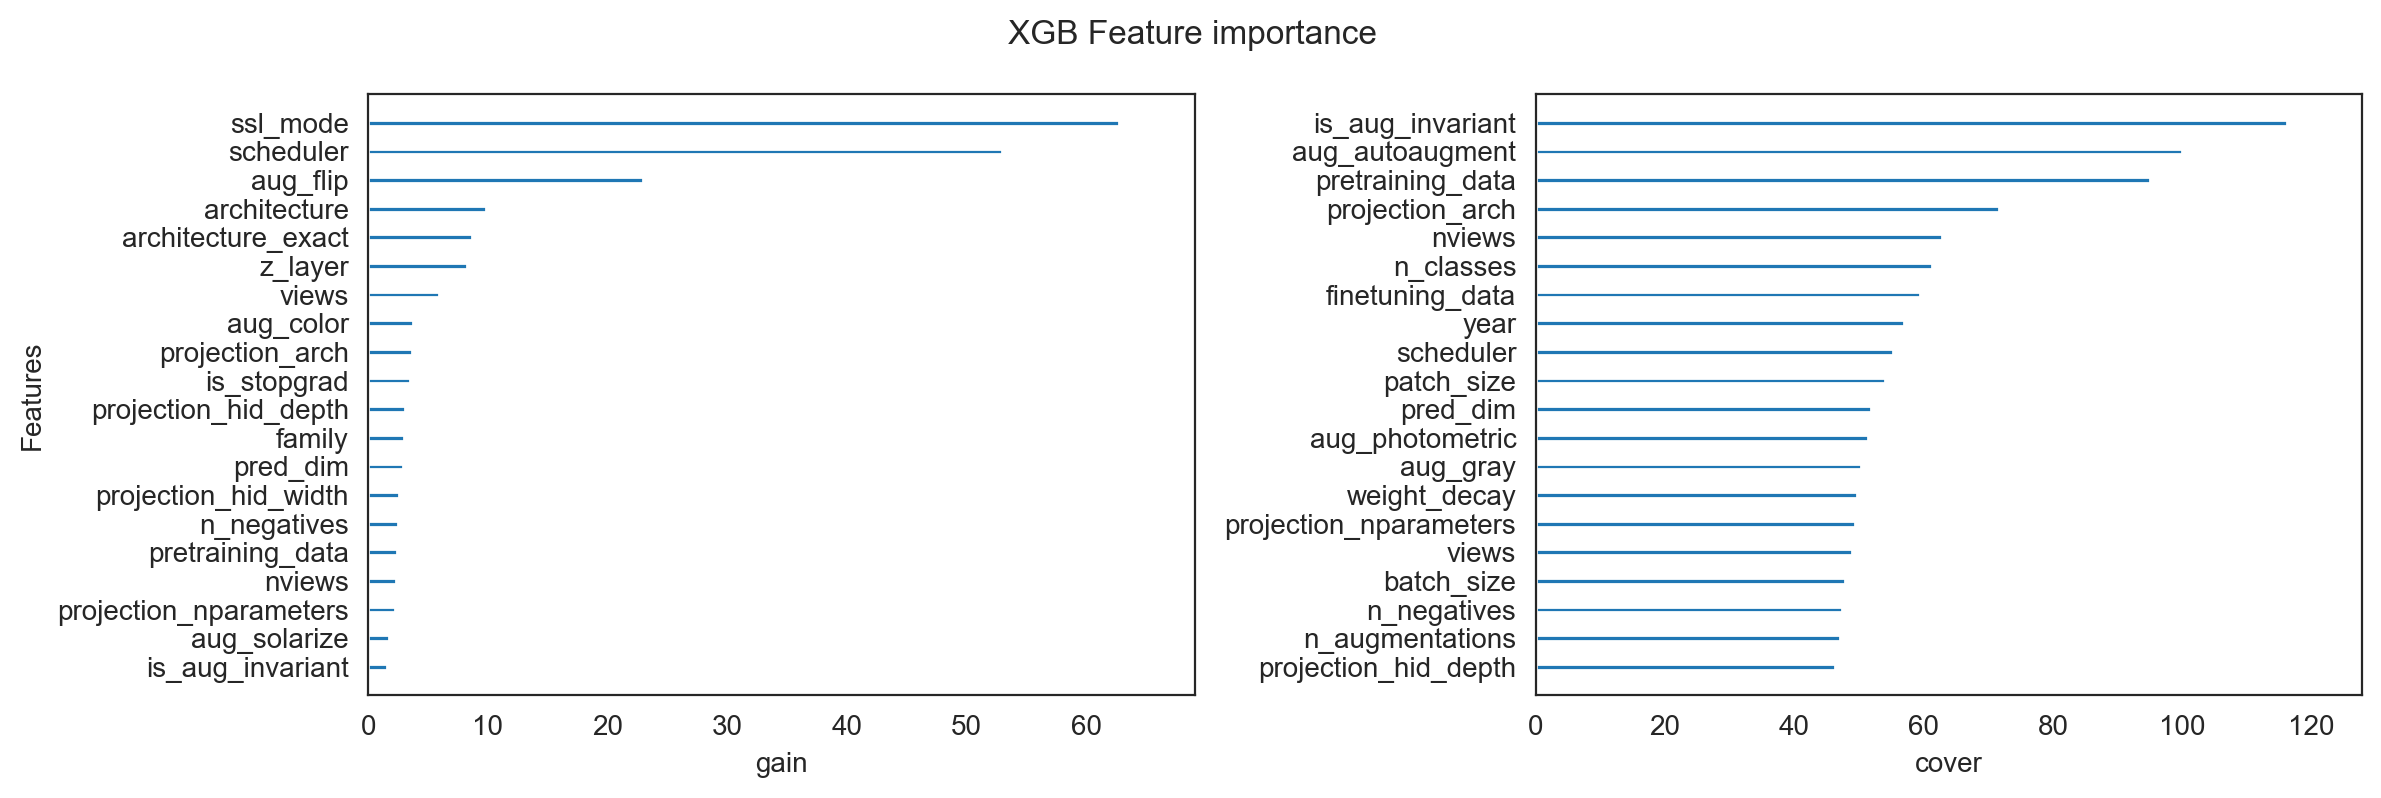

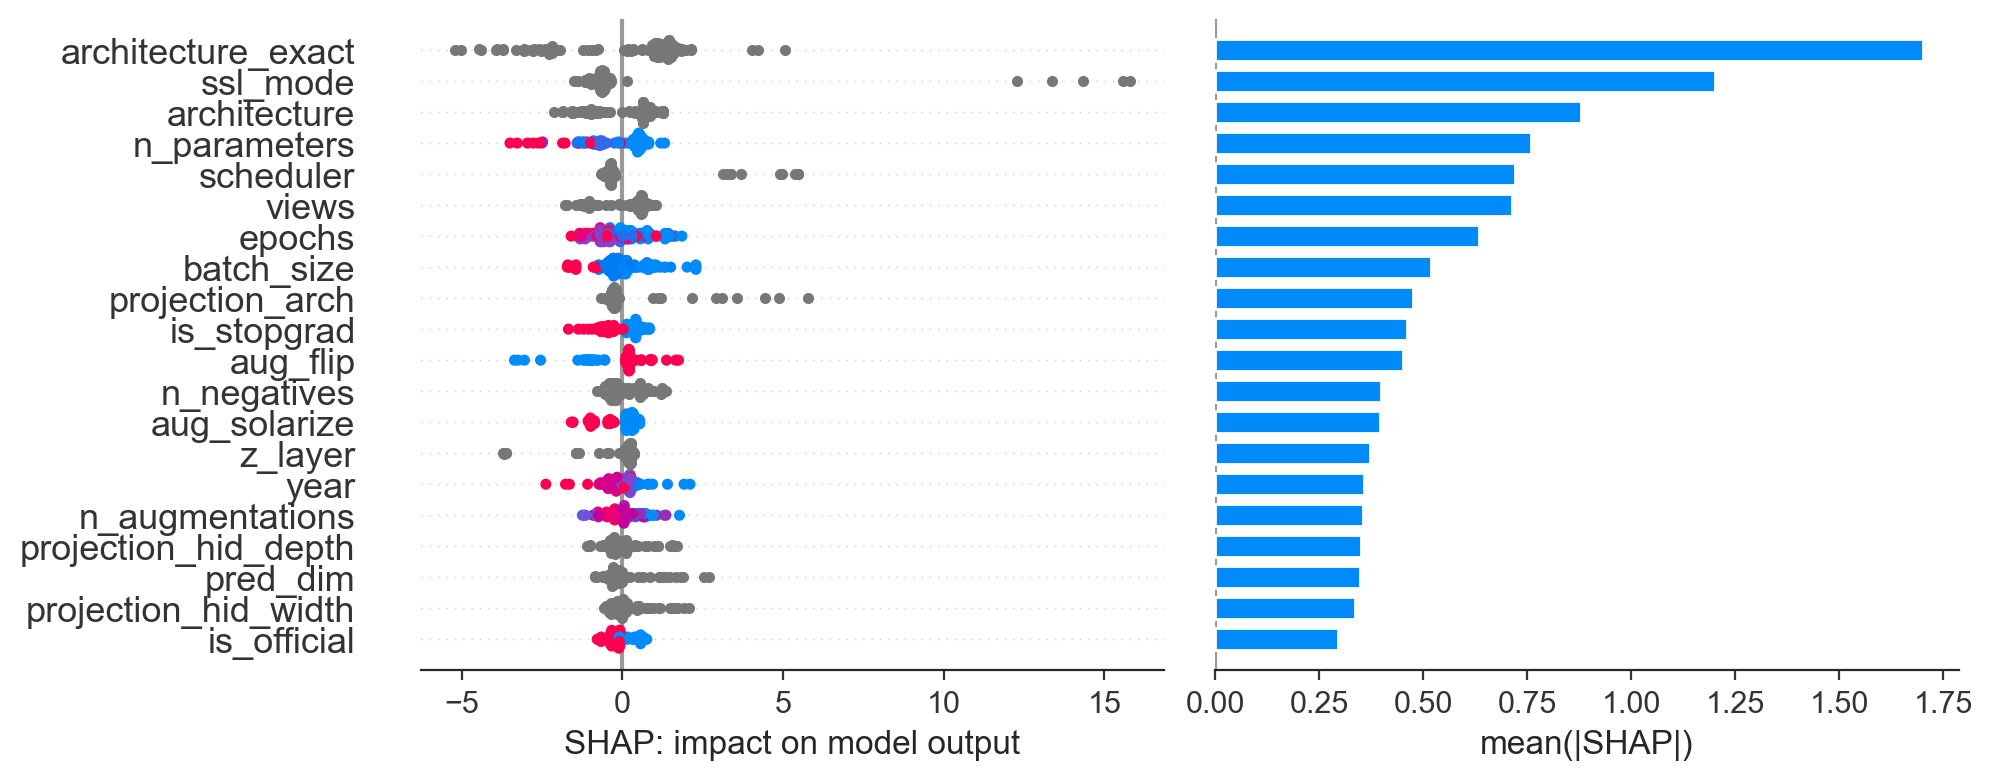

swav_rn50_ep400


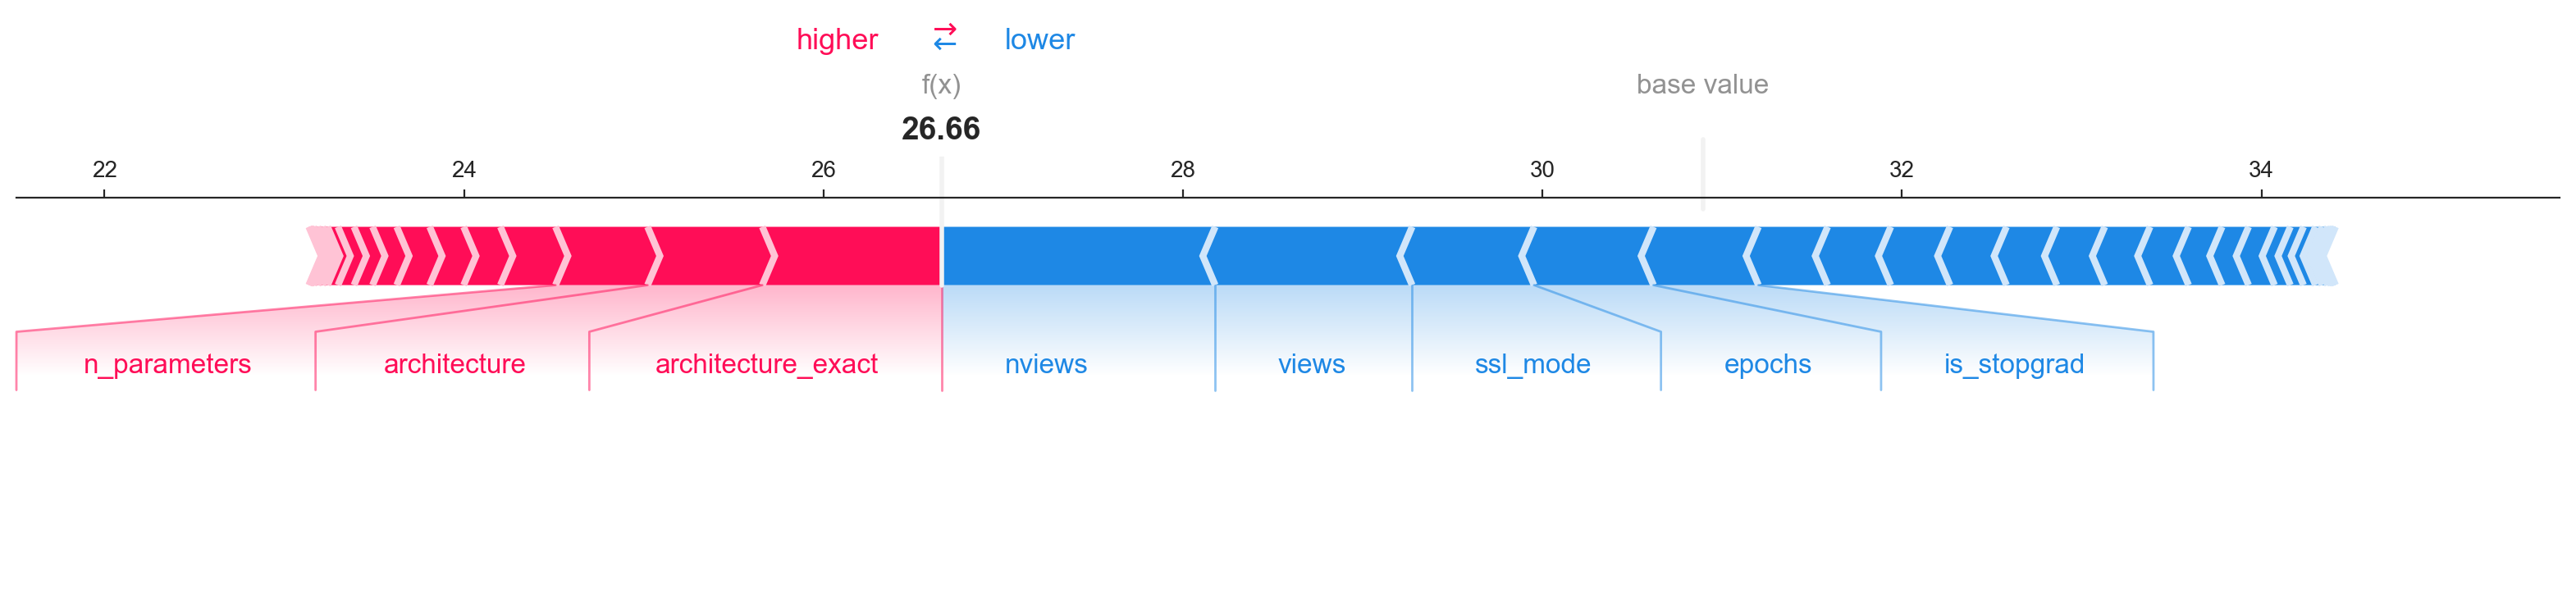

dino_vitS16


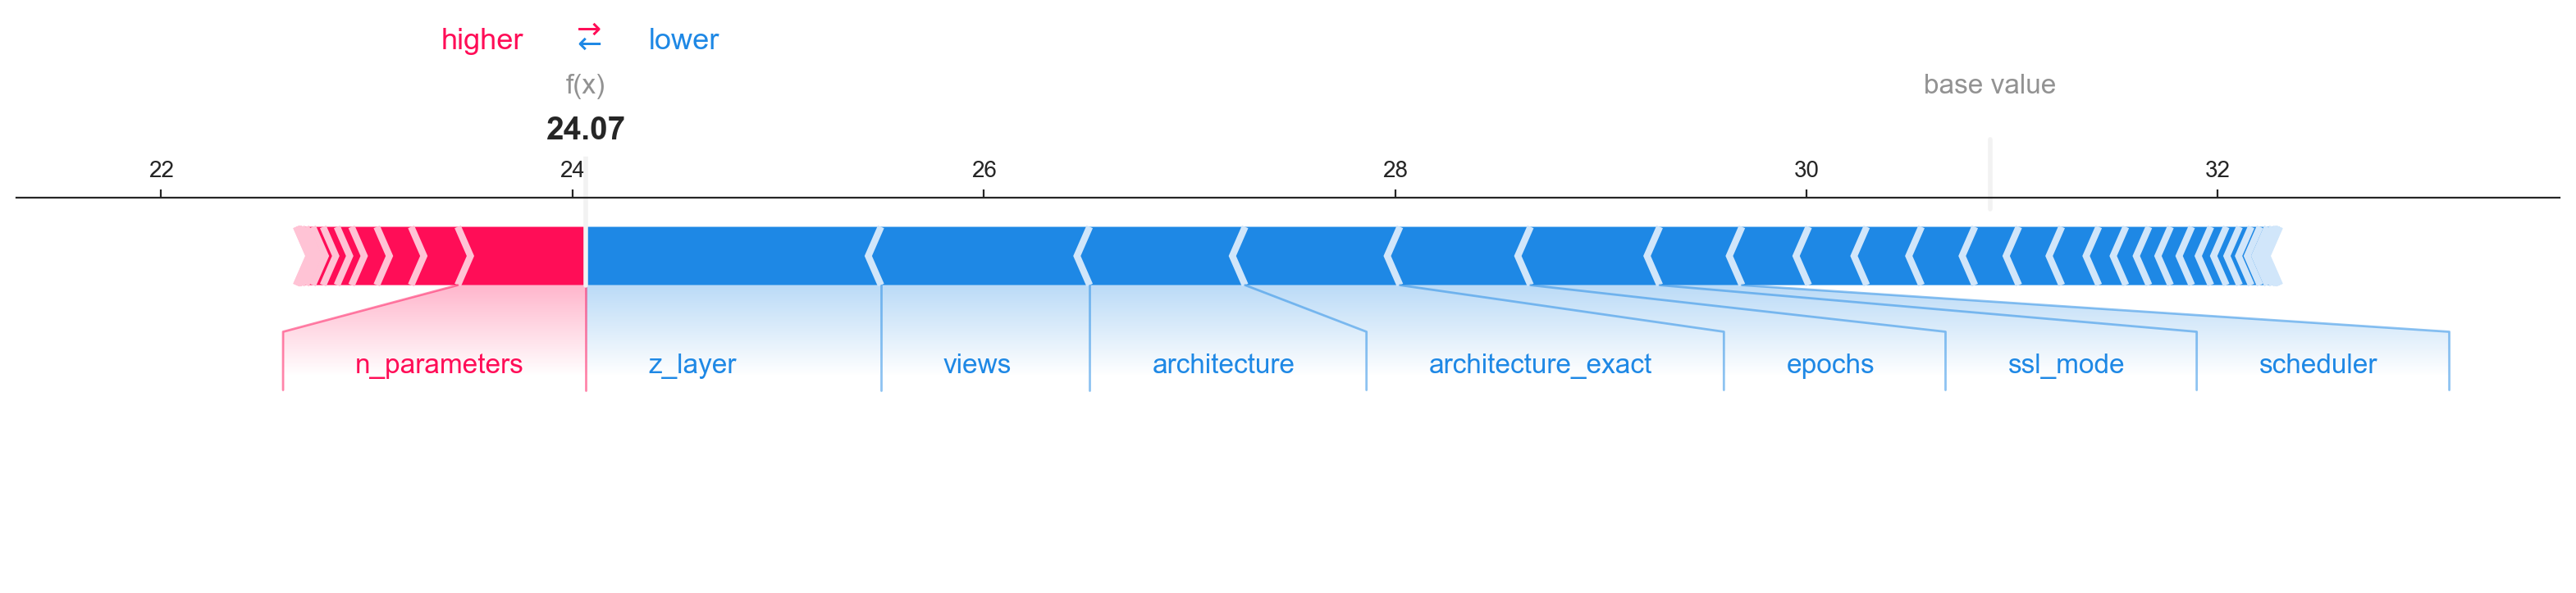

dissl_resnet50_d8192_e400_m6


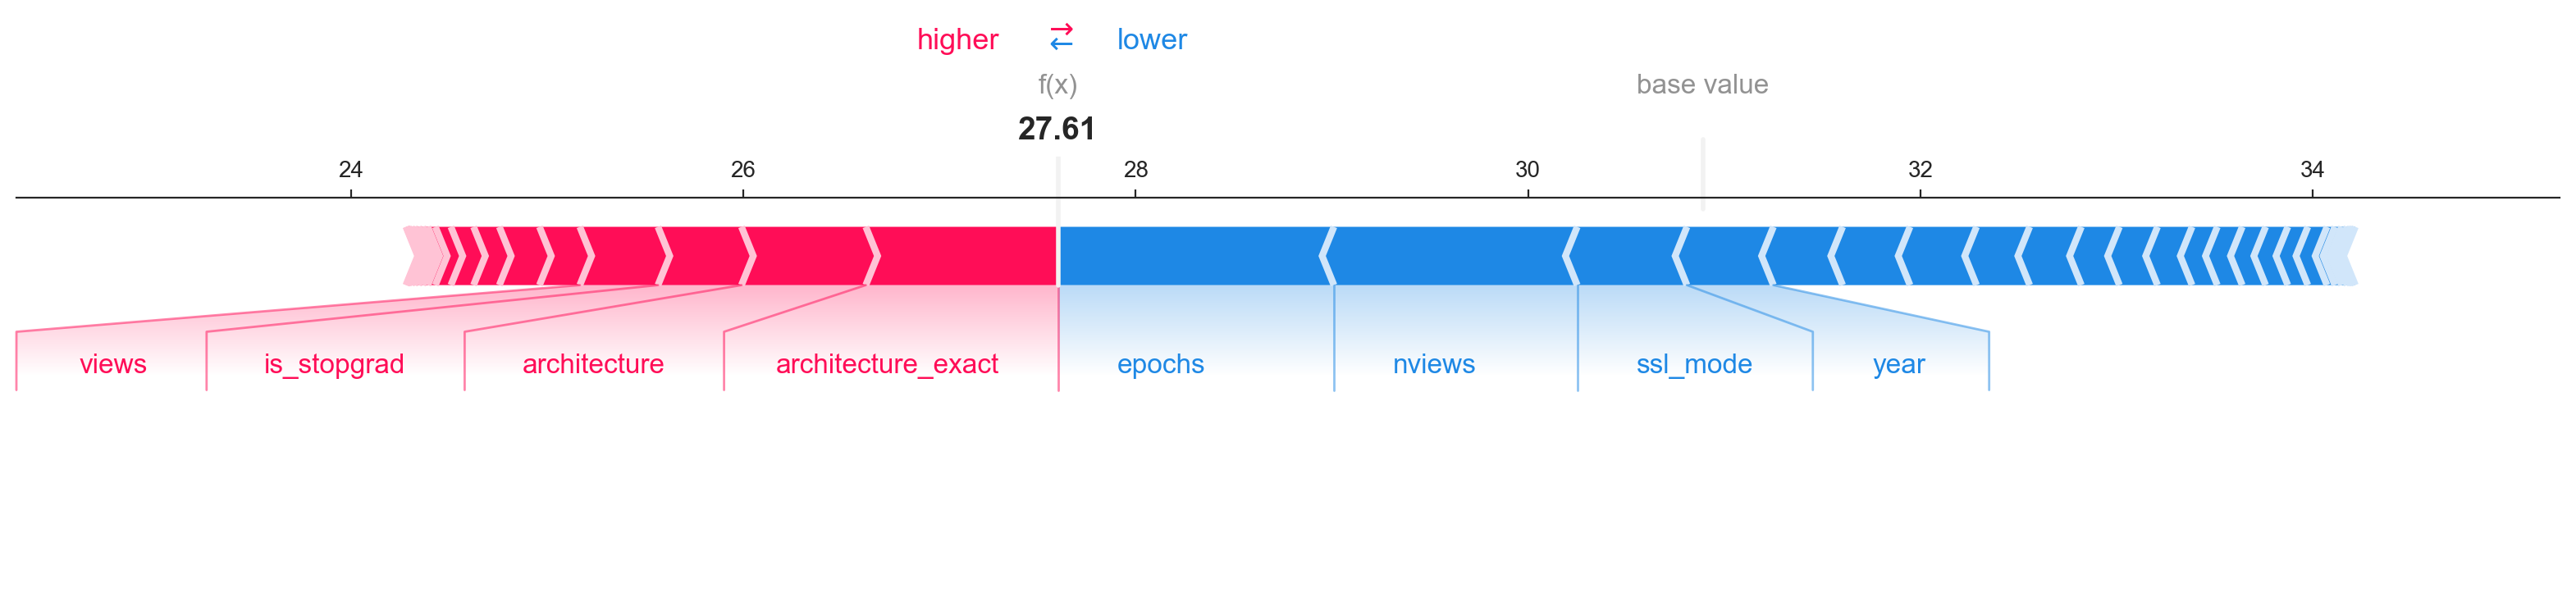

dissl_resnet50_dNone_e400_m6


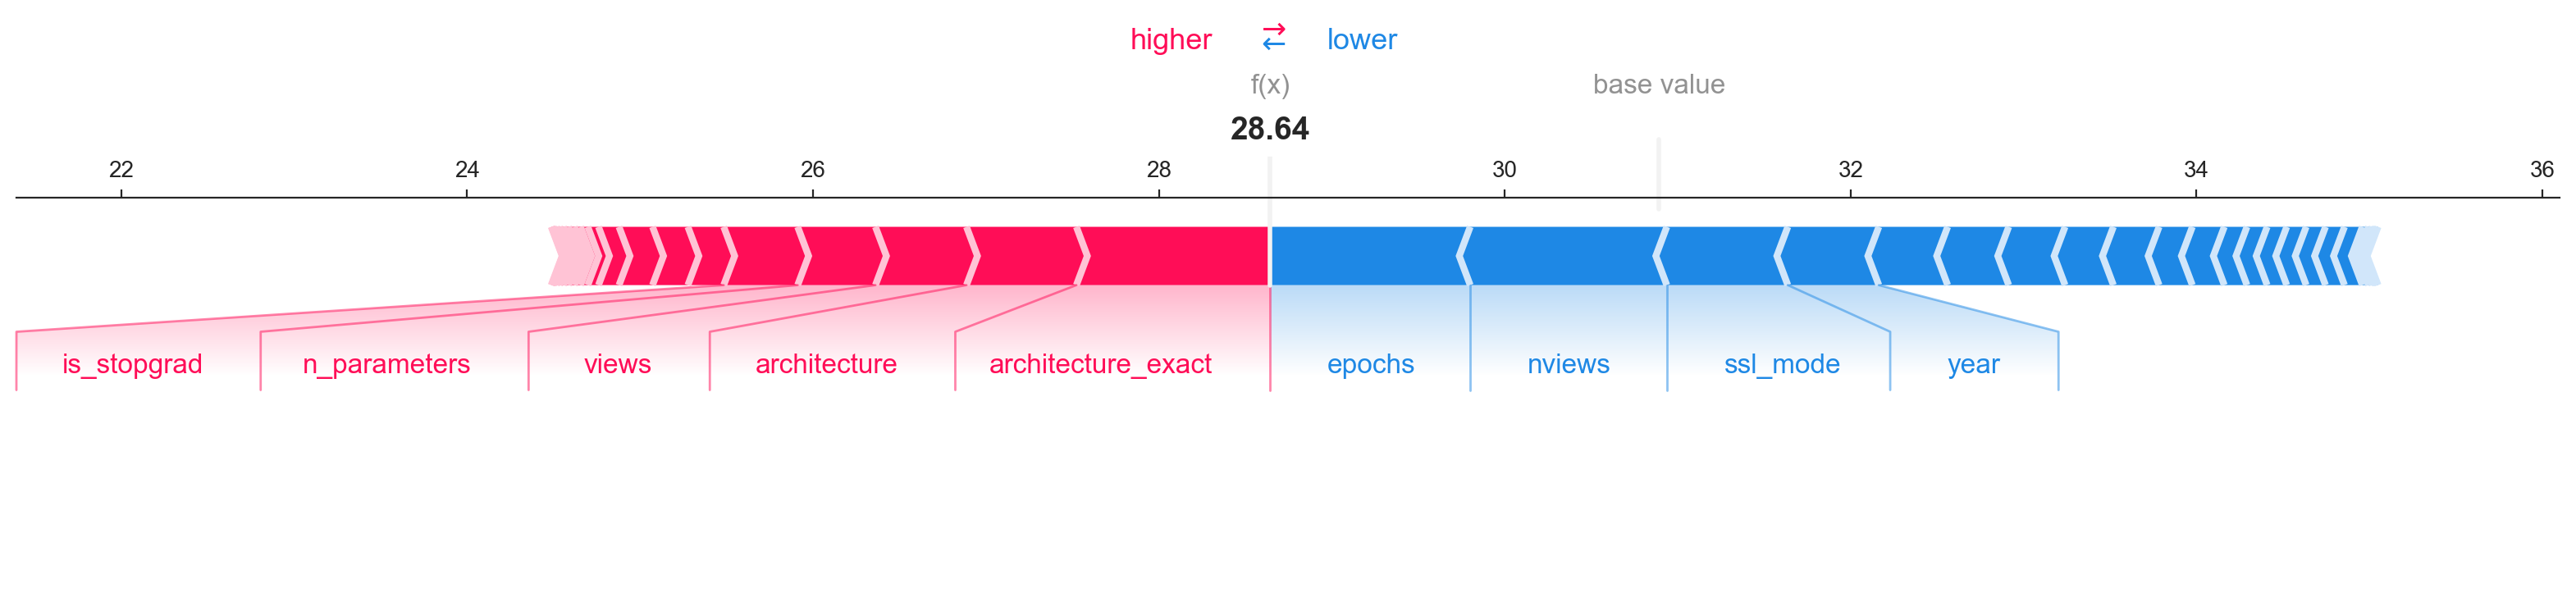

In [11]:
report_xgboost(all_xgb, X, y, n_feat=20, 
              examples=['swav_rn50_ep400', 'dino_vitS16',  'dissl_resnet50_d8192_e400_m6', 'dissl_resnet50_dNone_e400_m6'])


## Global analysis : selected features

In [12]:
is_train=False

features_to_keep= ["objective","architecture",'patch_size',"epochs",'batch_size','pretraining_data','projection_arch', 
                   'finetuning_data', "nviews", 'z_dim', "scheduler", "is_official", "optimizer", "family", "ssl_mode",
                   "n_parameters", "is_aug_invariant", "where"] 

X_sel,y_sel=prepare_sklearn(df, features_to_keep=features_to_keep)

folder = "notebooks/saved/"
if is_train:
    selected_xgb, selected_study = tune_std_xgb(X_sel, y_sel, is_force_exact=True)
    joblib.dump(selected_study, f"{folder}selected_study.pkl")
    selected_xgb.save_model(f"{folder}selected_xgb.json")
else:
    selected_xgb = xgb.Booster()
    selected_xgb.load_model(f"{folder}selected_xgb.json")
    selected_study = joblib.load(f"{folder}selected_study.pkl")

``multivariate`` option is an experimental feature. The interface can change in the future.
``group`` option is an experimental feature. The interface can change in the future.
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/50 [00:00<?, ?it/s]

Final 30-fold cv rmse=3.889761430931051


R2: 0.9831302606115093. RMSE: 1.2071522767580969


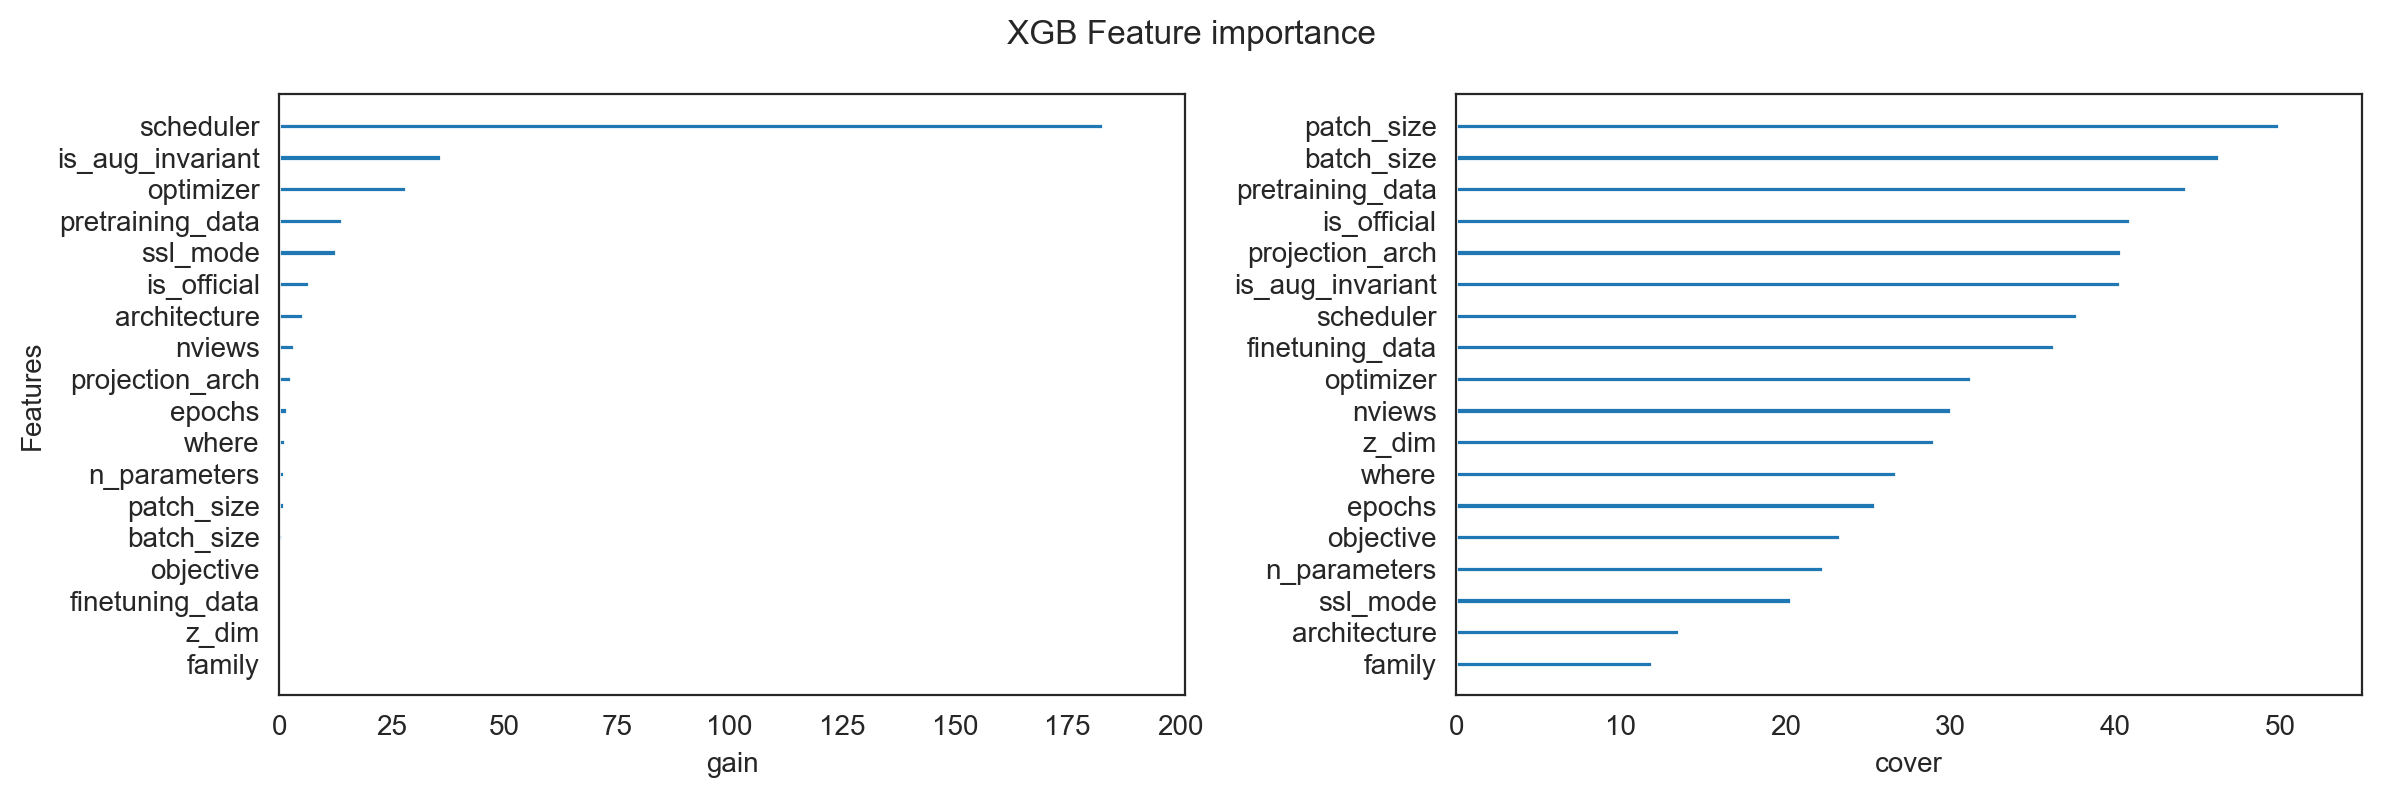

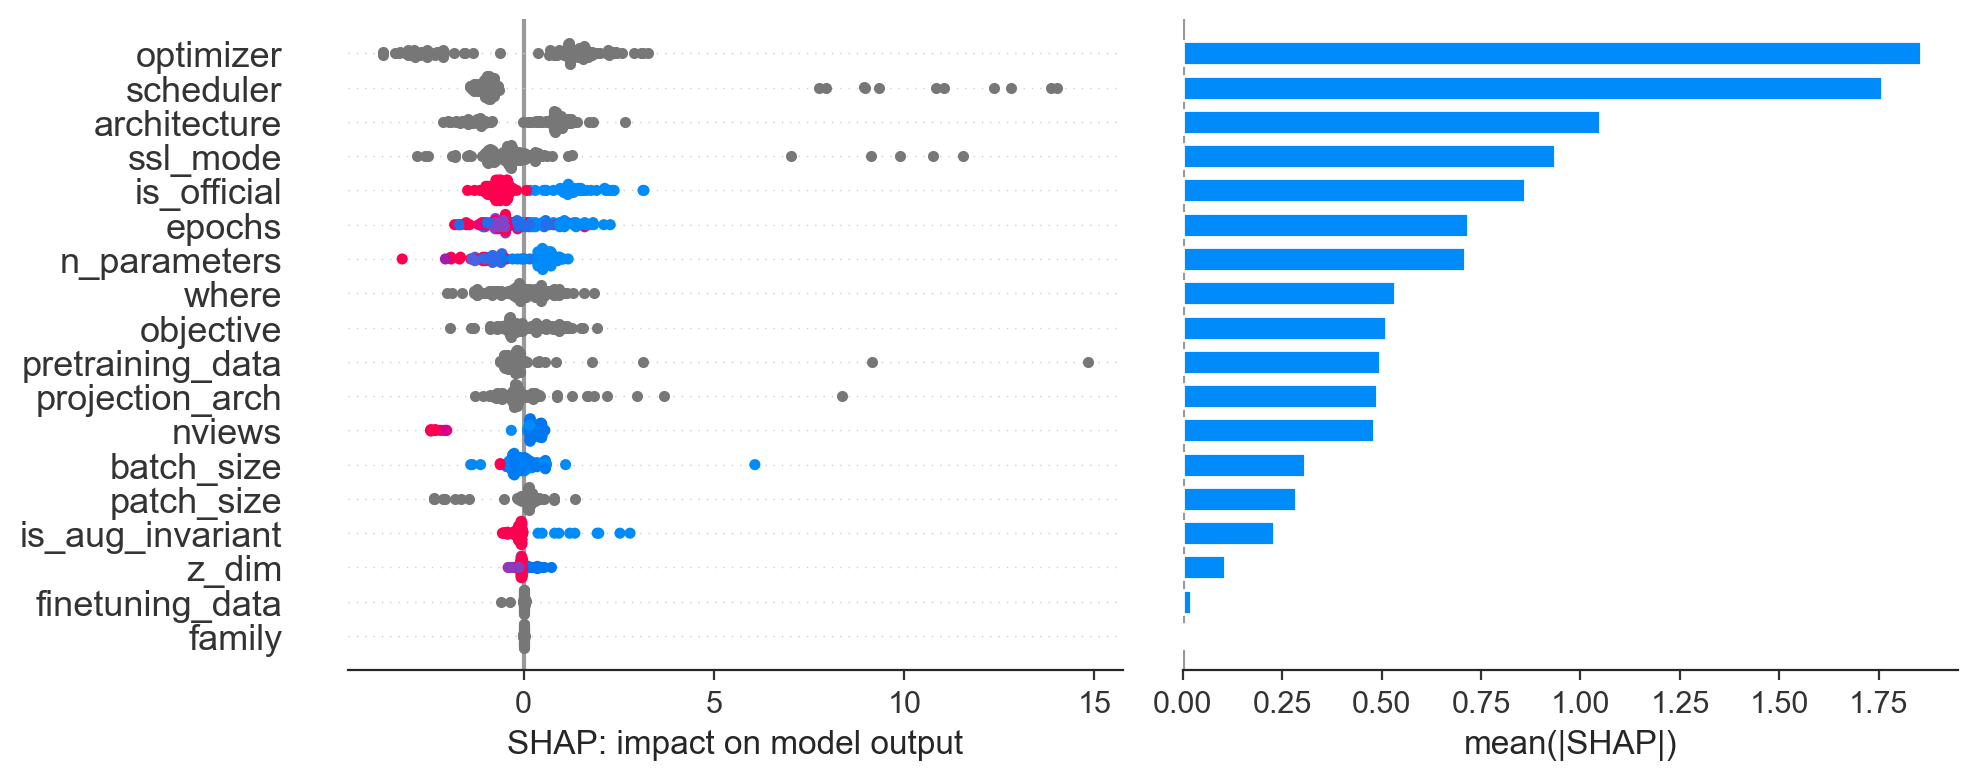

swav_rn50_ep400


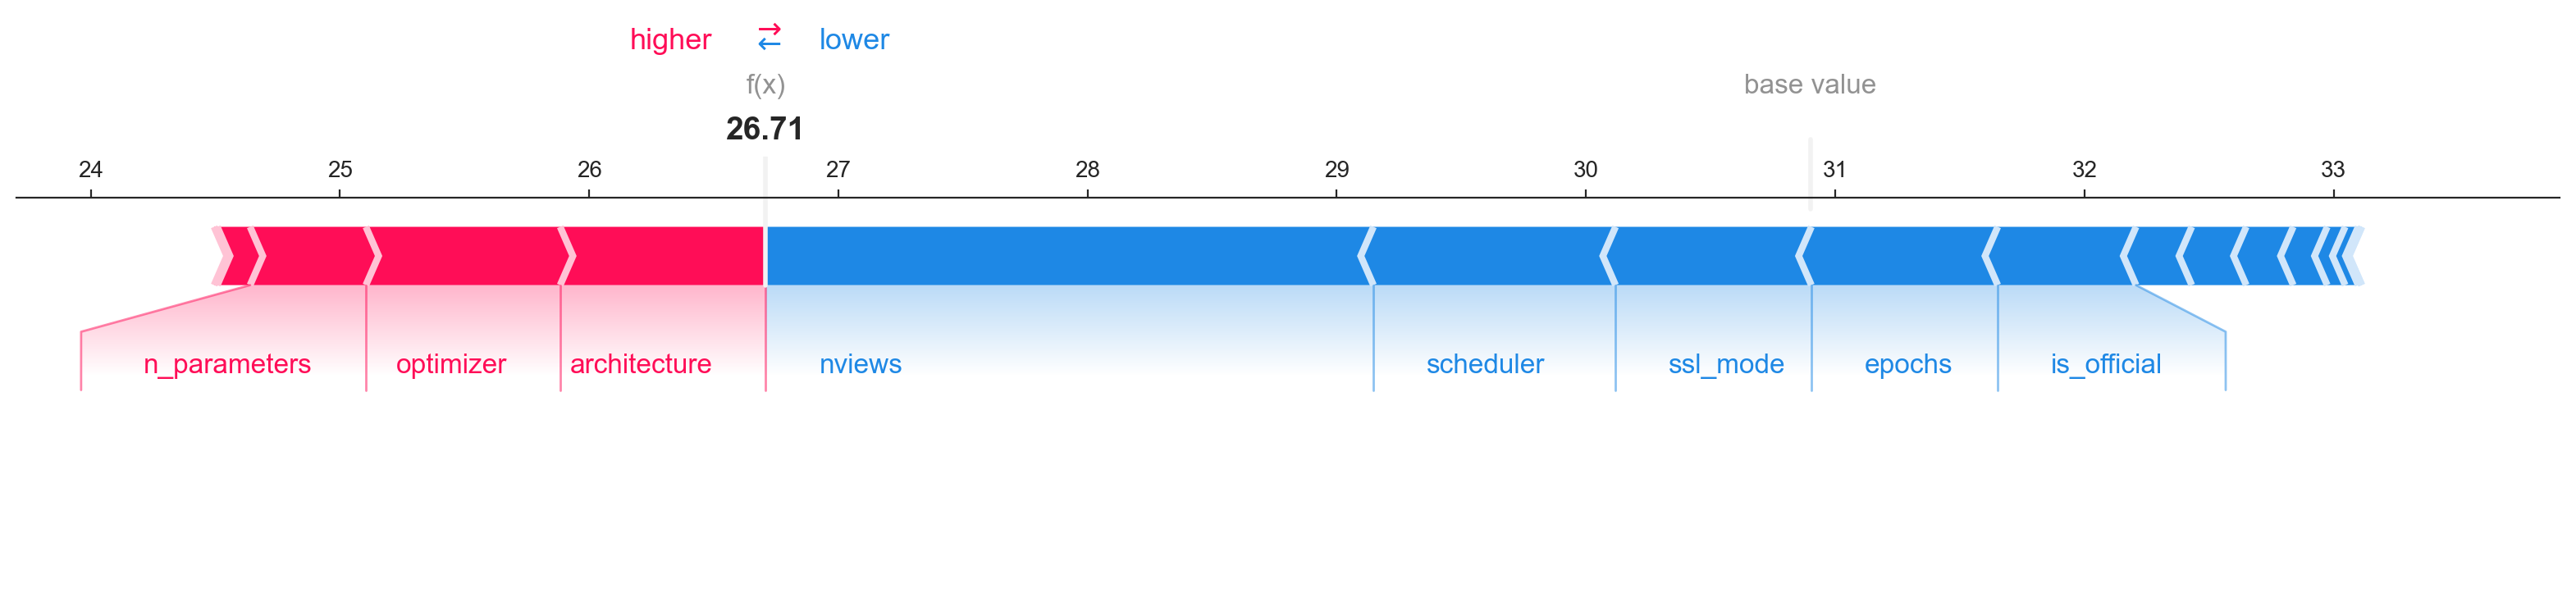

dino_vitS16


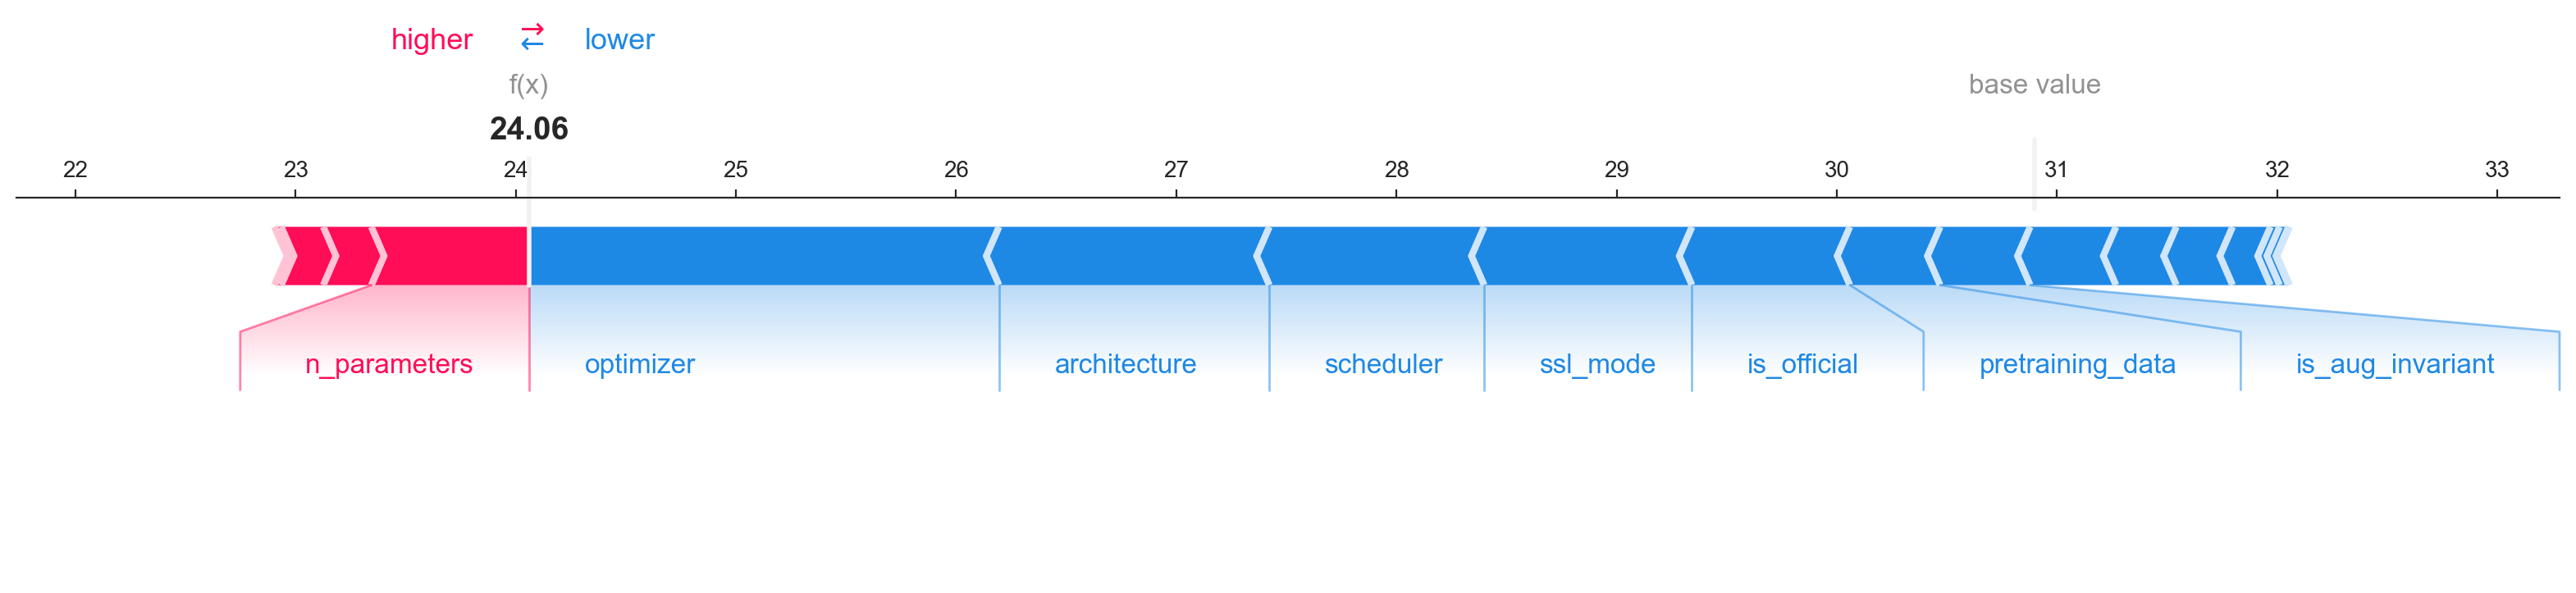

dissl_resnet50_d8192_e400_m6


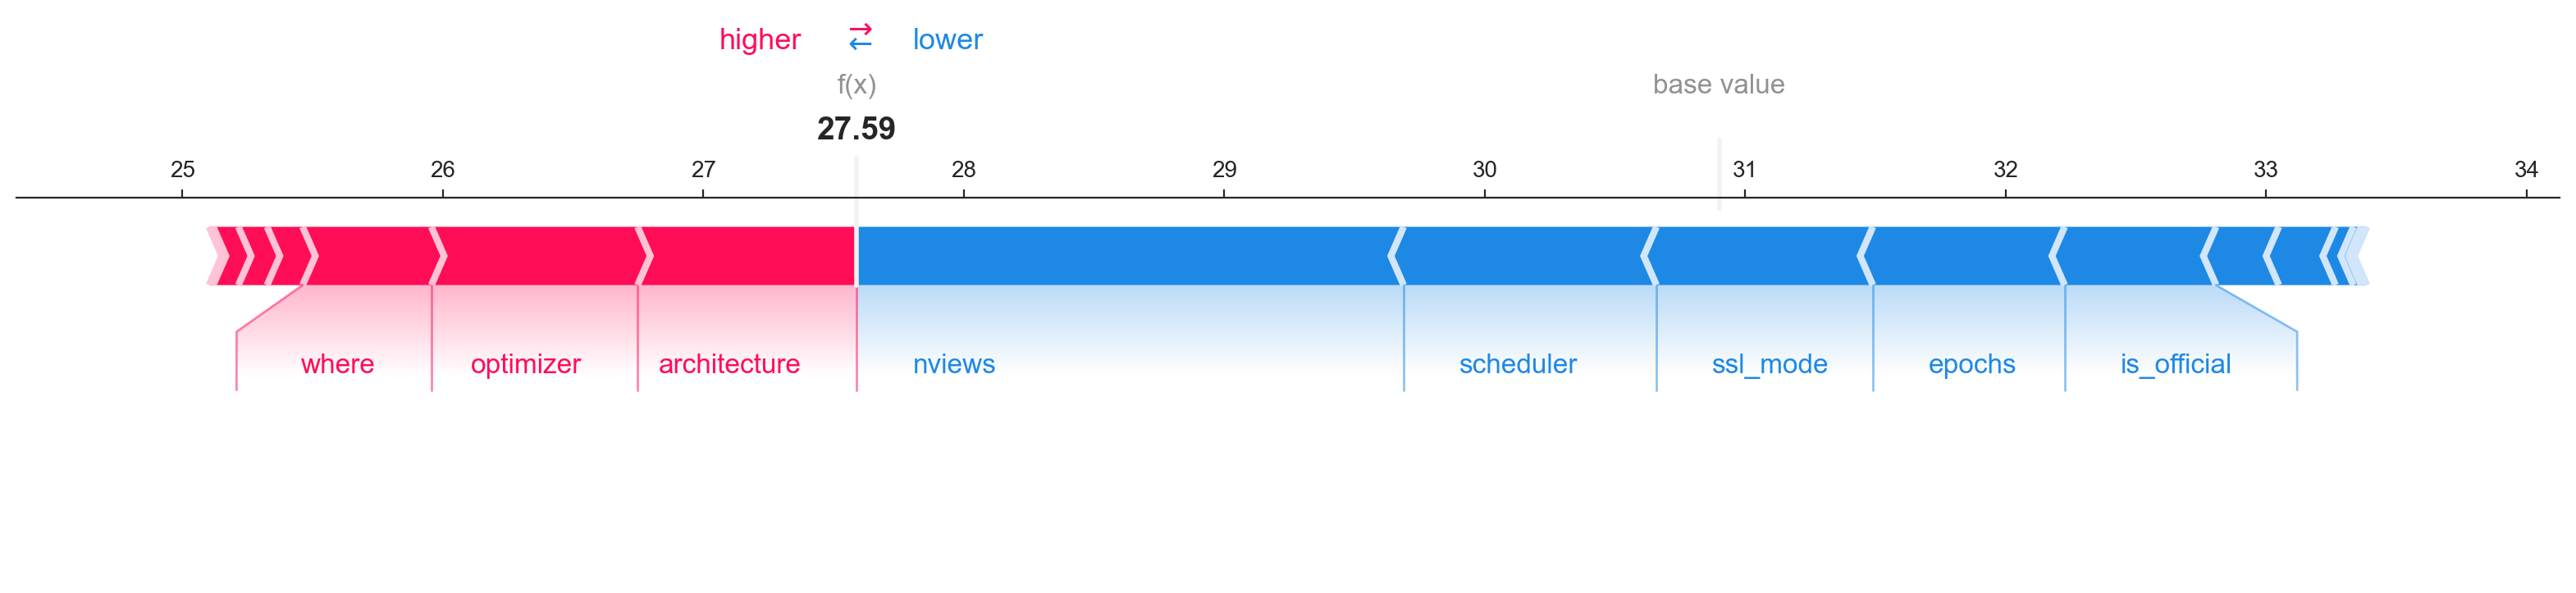

dissl_resnet50_dNone_e400_m6


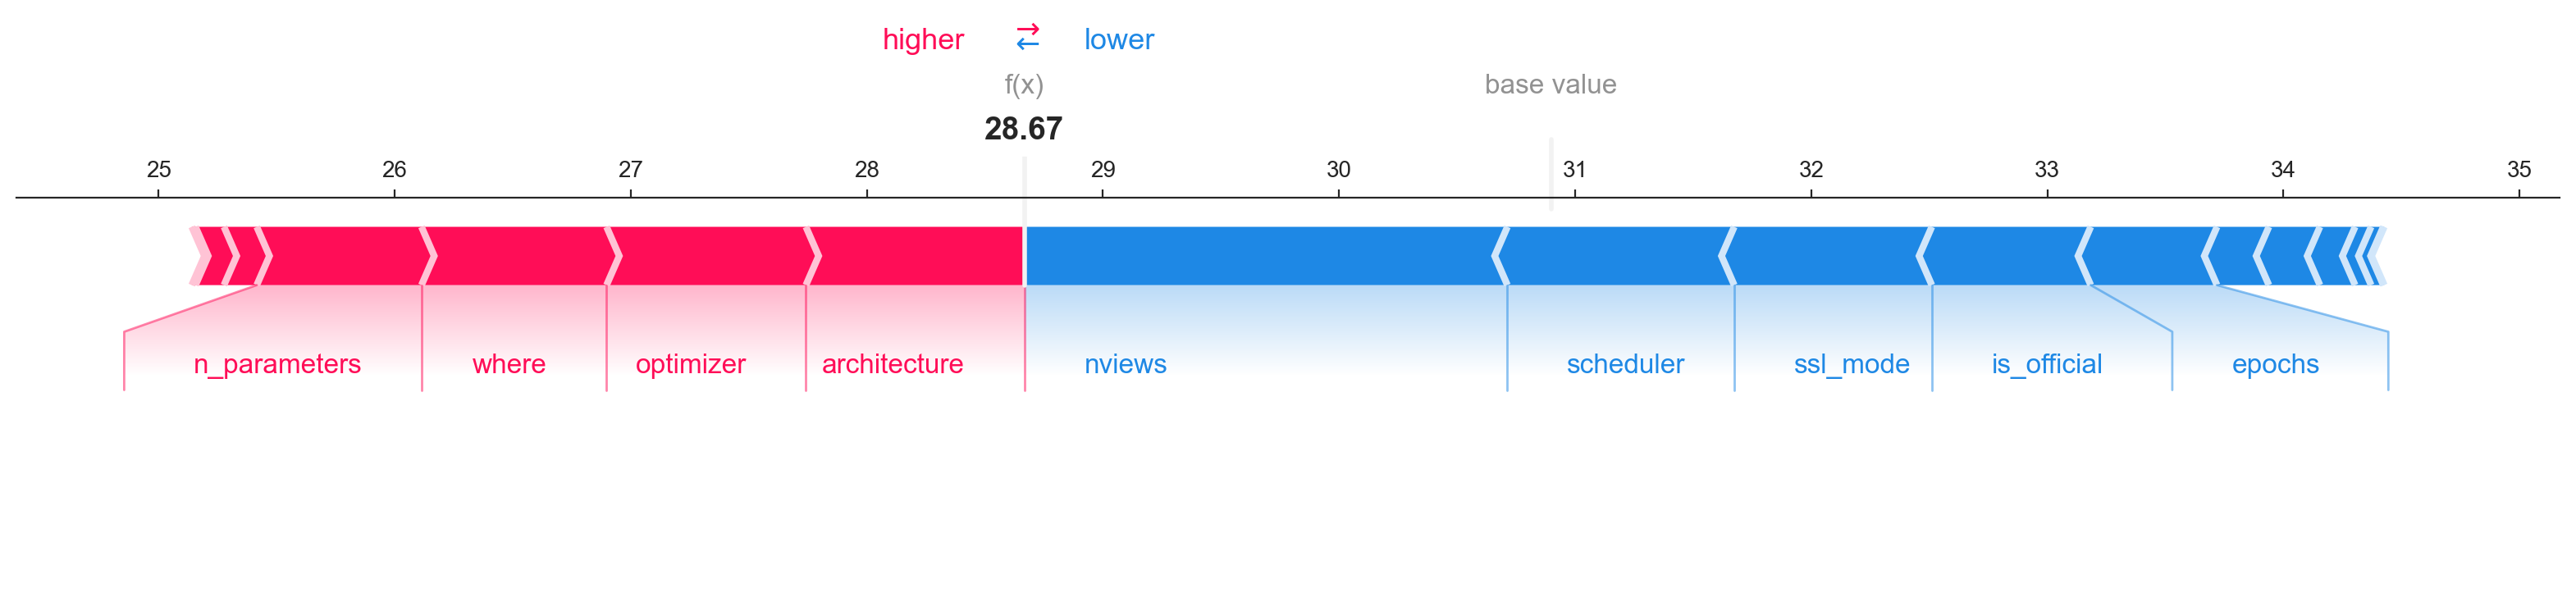

In [15]:
report_xgboost(selected_xgb, X_sel, y_sel, n_feat=20, 
              examples=['swav_rn50_ep400', 'dino_vitS16',  'dissl_resnet50_d8192_e400_m6', 'dissl_resnet50_dNone_e400_m6'])


## Global analysis : minimal features

In [18]:
is_train=False

features_to_keep= ["objective","architecture",'patch_size',"epochs",'batch_size','pretraining_data','projection_arch', 
                   'finetuning_data', "nviews", 'z_dim'] 

X_min,y_min=prepare_sklearn(df, features_to_keep=features_to_keep)

folder = "notebooks/saved/"
if is_train:
    minimal_xgb, minimal_study = tune_std_xgb(X_min, y_min, is_force_exact=True)
    joblib.dump(minimal_study, f"{folder}minimal_study.pkl")
    minimal_xgb.save_model(f"{folder}minimal_xgb.json")
else:
    minimal_xgb = xgb.Booster()
    minimal_xgb.load_model(f"{folder}minimal_xgb.json")
    minimal_study = joblib.load(f"{folder}minimal_study.pkl")

``multivariate`` option is an experimental feature. The interface can change in the future.
``group`` option is an experimental feature. The interface can change in the future.
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/50 [00:00<?, ?it/s]

Final 30-fold cv rmse=4.990306891507321


R2: 0.9826357604384457. RMSE: 1.2247170262132532


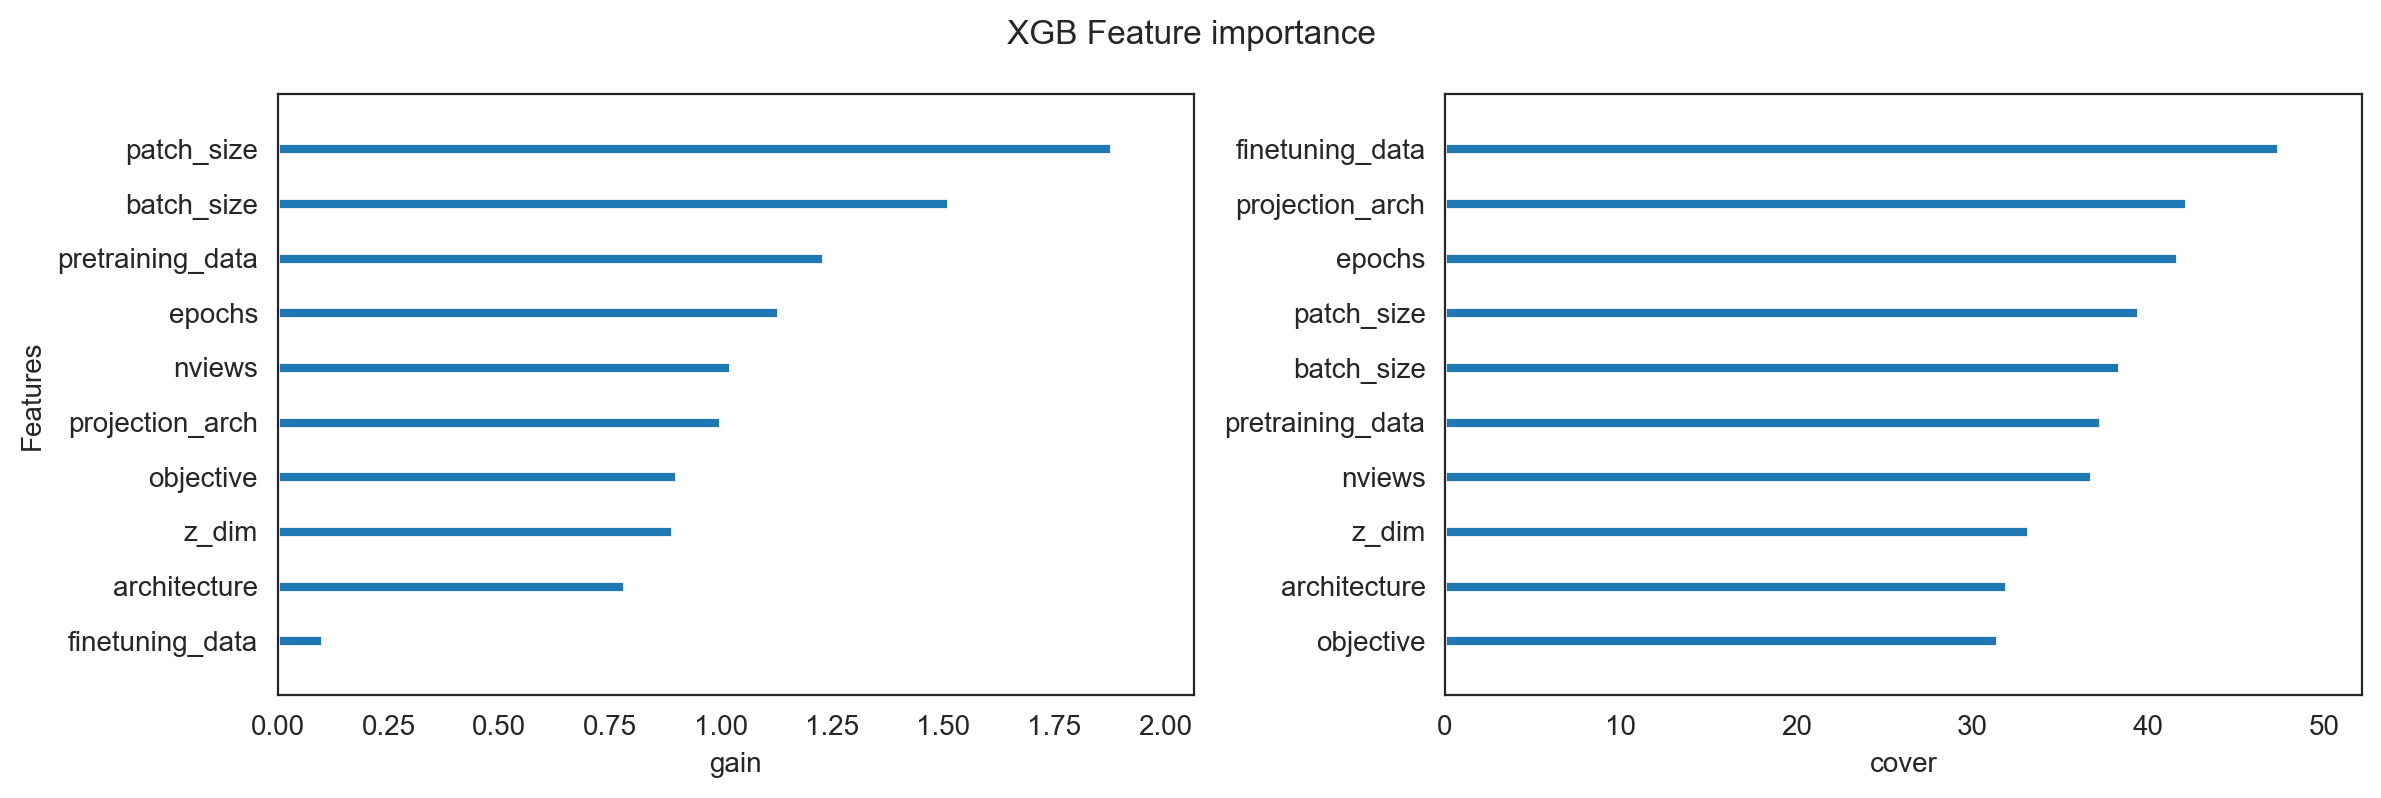

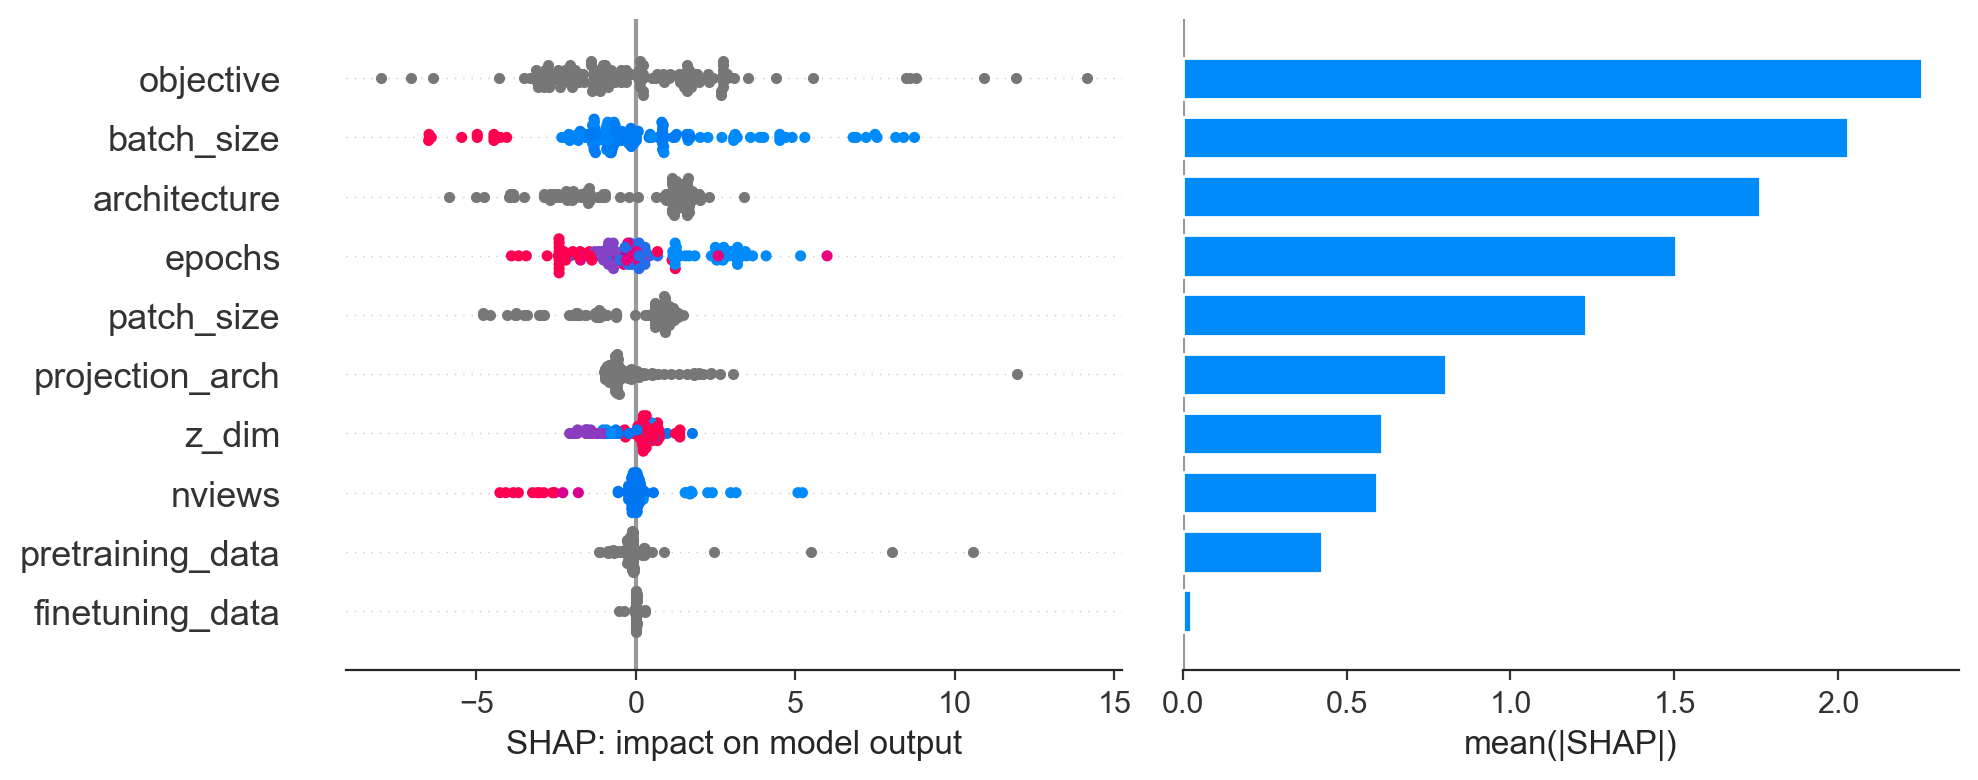

swav_rn50_ep400


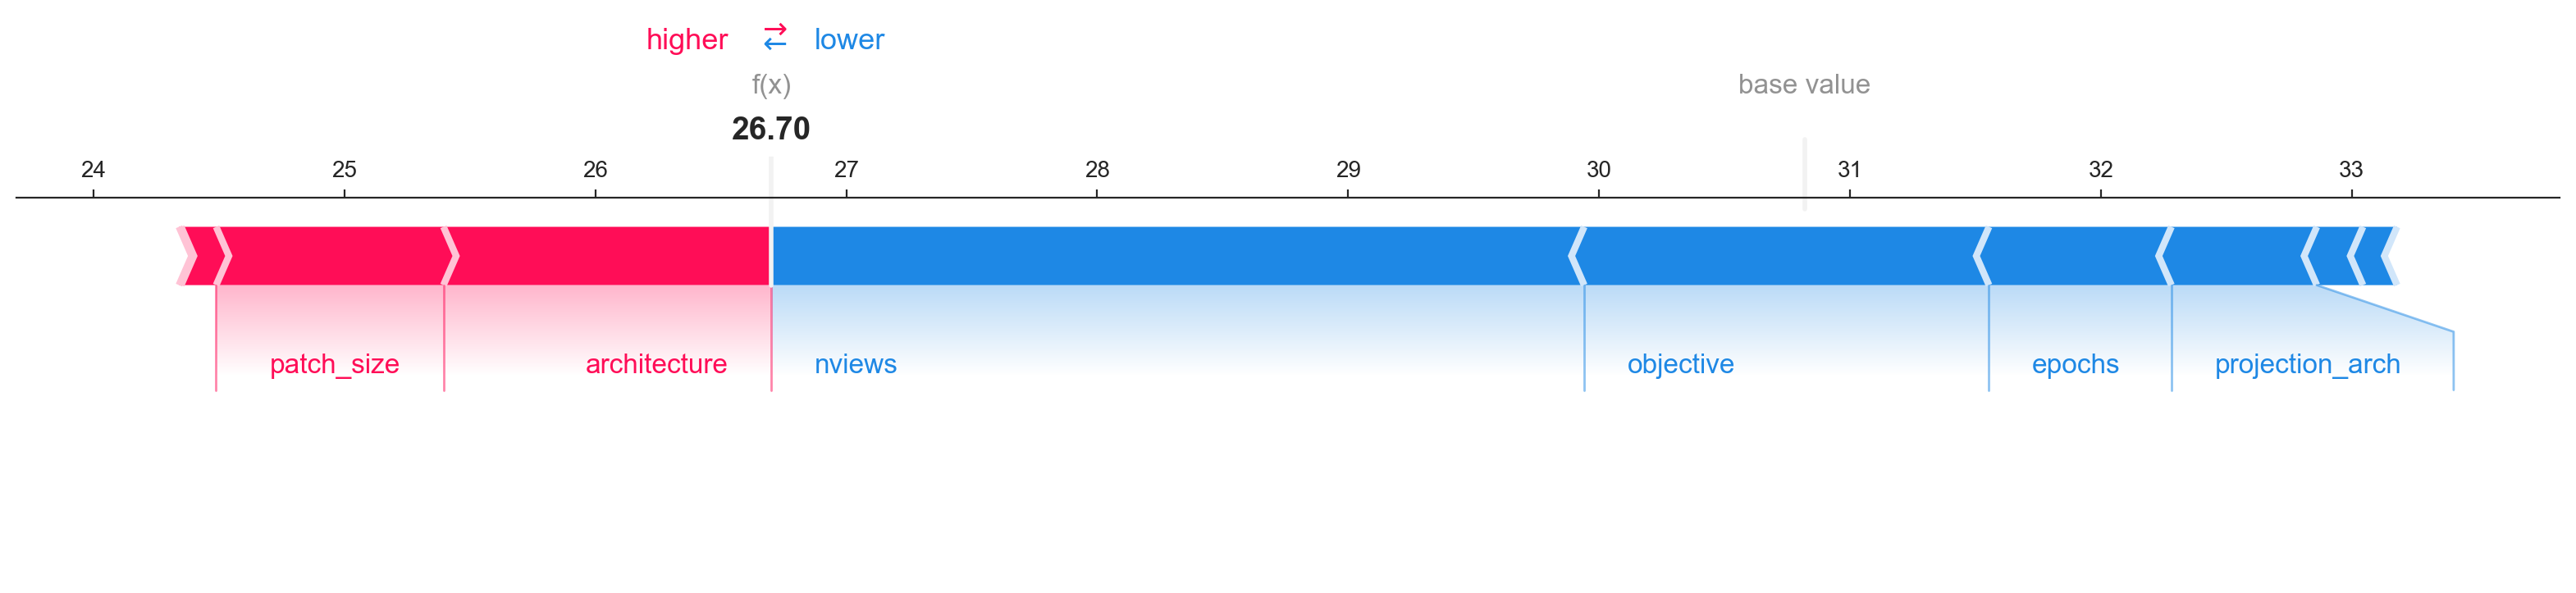

dino_vitS16


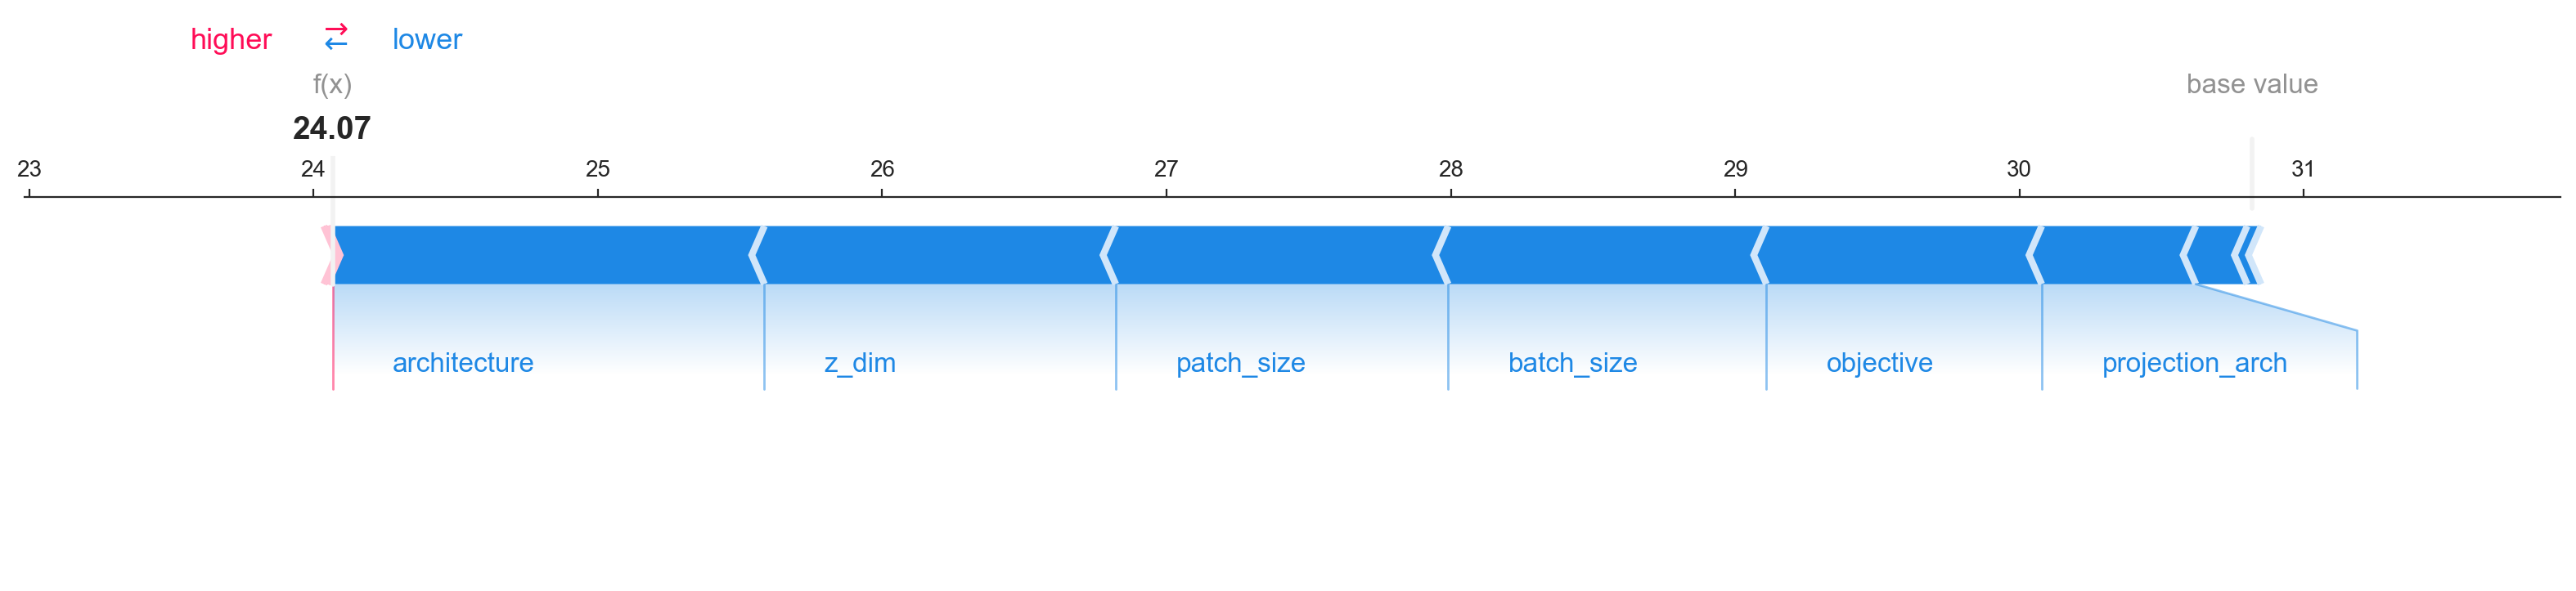

dissl_resnet50_d8192_e400_m6


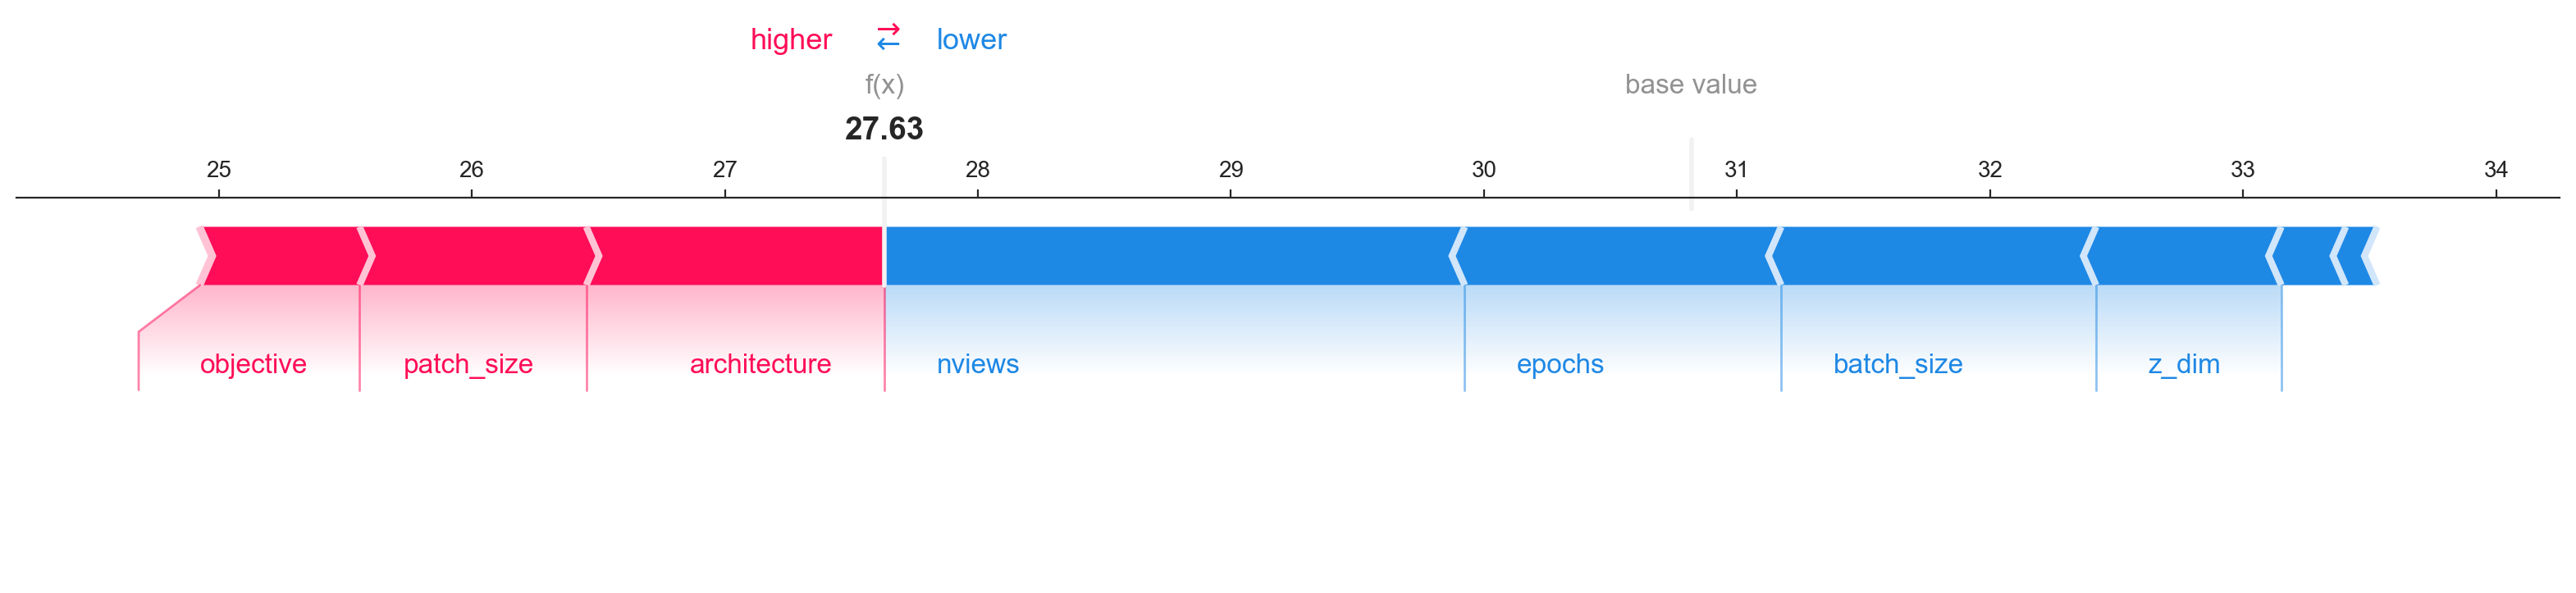

dissl_resnet50_dNone_e400_m6


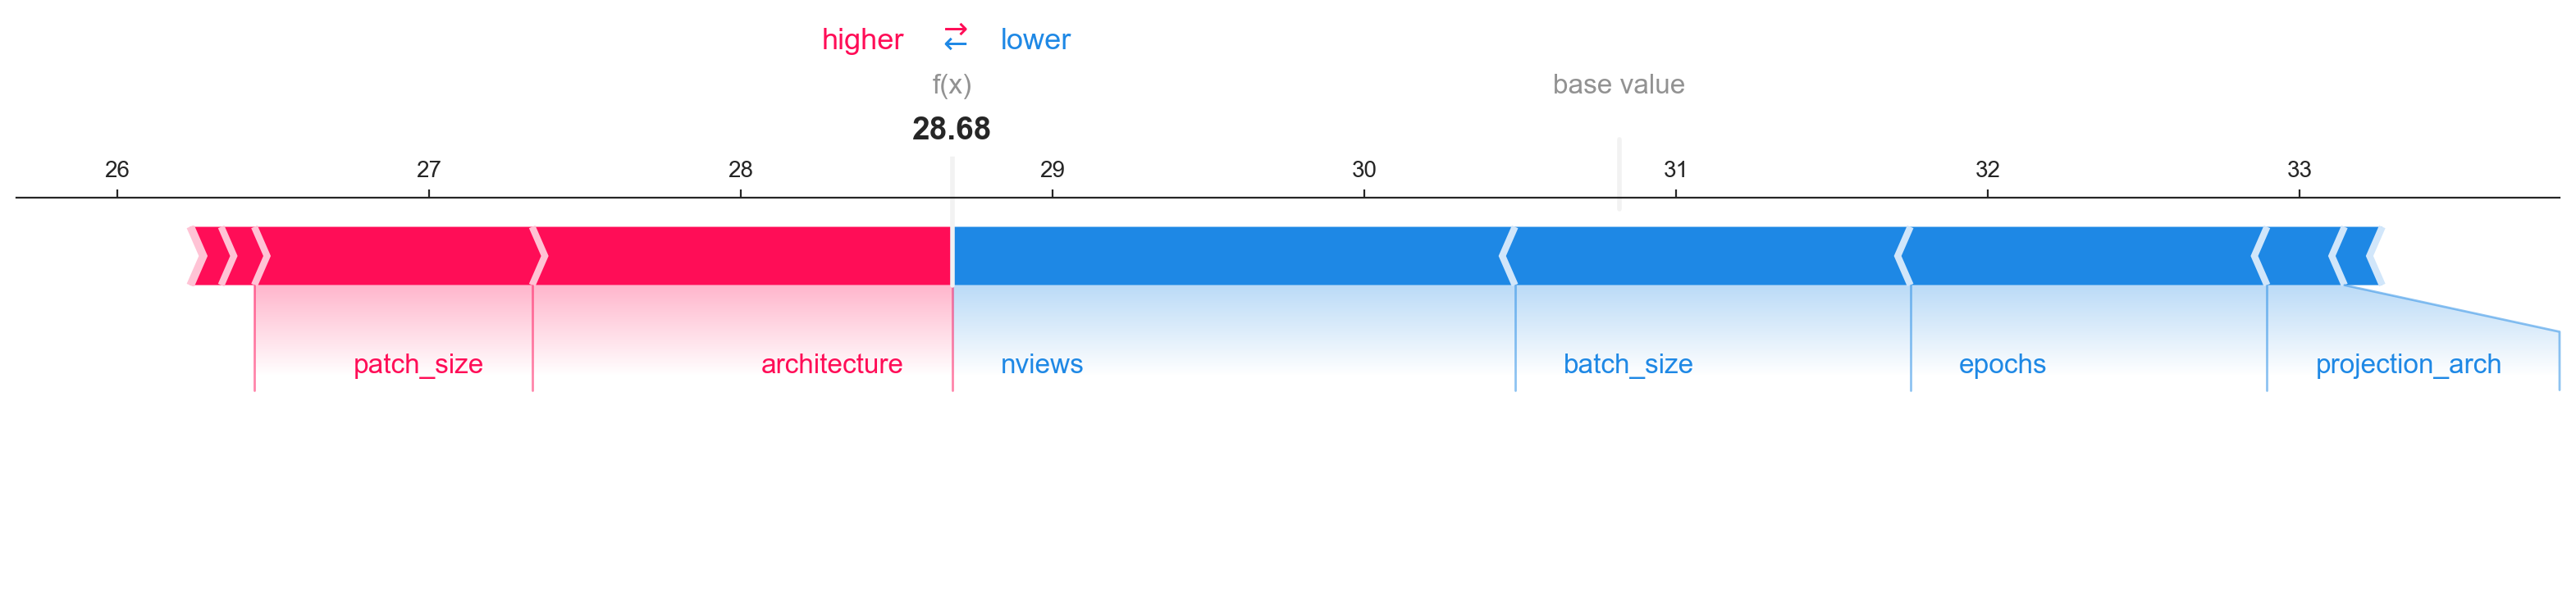

In [19]:
report_xgboost(minimal_xgb, X_min, y_min, n_feat=20, 
              examples=['swav_rn50_ep400', 'dino_vitS16',  'dissl_resnet50_d8192_e400_m6', 'dissl_resnet50_dNone_e400_m6'])


## Global analysis : causal features